In [1]:
import matplotlib as mpl
import os, sys
mpl.use('Agg')
from LiteNet import *
import tensorflow as tf
import autograd.numpy as np
from autograd import grad, getval
import h5py as h5
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from time import time
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm, trange
from autograd.scipy.stats import norm
np.set_printoptions(precision=3, linewidth=120)

%matplotlib inline

In [2]:
from nystrom_kexpfam.data_generators.Gaussian import GaussianGridWrapped
from nystrom_kexpfam.data_generators.Ring import Ring
from nystrom_kexpfam.data_generators.Dataset import GlassPosteriorDataset

from nystrom_kexpfam.log import logger
from nystrom_kexpfam.visualisation import visualise_array_2d

from nystrom_kexpfam.estimators.KMCLite import KMCLite

INFO: 2018-05-10 22:52:18,640: log.<module>(): Global logger initialised with loglevel 20
INFO: 2018-05-10 22:52:18,824: log.<module>(): Global logger initialised with loglevel 20
/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 164, in <module>
    use(config.device)
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 151, in use
    init_dev(device)
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 68, in init_dev
    context.cudnn_handl

In [3]:
class Spiral():
    
    def __init__(self, sigma=0.1, D = 2, r_scale=1, starts=[0.0], length=2*np.pi):
        
        self.sigma = sigma
        self.L= length
        self.r_scale = r_scale
        self.D = D
        self.center_eps = 0.01
        self.starts= starts
        self.nstart= len(starts)
        self.name = "spiral"

    def sample(self, n):
        
        data = np.zeros((n+self.nstart, self.D))
        batch_size = np.floor_divide(n+self.nstart,self.nstart)
        
        for si, s in enumerate(self.starts):
            m = np.floor_divide(n,self.nstart)
            data[si*batch_size:(si+1)*batch_size] = self.sample_branch(batch_size, s)
        return  data[:n,:]
        
    def sample_branch(self, n, start):
        
        a = np.random.uniform(0,1,n)
        a = self.L * np.cbrt(a) + start

        r = (a-start)*self.r_scale
        
        data = np.zeros((n,self.D))
        data[:,0] = r * np.cos(a)
        data[:,1] = r * np.sin(a)
    
        data += np.random.randn(*data.shape)* self.sigma * ((a-start)/self.L+self.center_eps)[:,None]

        return data

class Funnel():
    
    def __init__(self, sigma=3.0, D=2, lim=np.inf):
    
        self.sigma=sigma
        self.D=D
        self.lim=lim
        self.low_lim = 0.000
        self.thresh   = lambda x: np.clip(np.exp(-x), self.low_lim, self.lim)
        self.name="funnel"
        
        
    def sample(self, n):
        
        data = np.random.randn(n, self.D)
        data[:,0]  *= self.sigma
        v =  self.thresh(data[:,0:1])
        data[:,1:] = data[:,1:] * np.sqrt(v)
        return data
    
    def grad_multiple(self, x):
        
        N = x.shape[0]
        grad = np.zeros((N, self.D))
        x1 = x[:,0]
        
        v = np.exp(-x1)
        
        dv  = -1*v
        dlv = -np.ones_like(v)
        
        dv[(v) < self.low_lim] = 0
        dv[(v) > self.lim] = 0
        
        dlv[(v) < self.low_lim] = 0
        dlv[(v) > self.lim] = 0
        
        grad[:,0] = -x1/self.sigma**2 - (self.D-1)/2.0 * dlv - 0.5*(x[:,1:]**2).sum(1) * (-dv)/v/v
        grad[:,1:]= - x[:,1:] / self.thresh(x1)[:,None]
        return grad
    
    def logpdf(self, x):
        v = self.thresh(x[:,0])
        return norm.logpdf(x[:,0], 0, self.sigma) + norm.logpdf(x[:,1:], 0, np.sqrt(v)[:,None]).sum(1)

ns = 100
D = 50
p = Funnel(sigma=2, lim=np.inf, D=D)
x = p.sample(ns)

dlogp = grad(p.logpdf)
gt = np.zeros((ns,p.D))
for i in range(ns):
    gt[i,:] = dlogp(x[i:i+1,:])
    
ge = p.grad_multiple(x)
for i in range(p.D):
    print np.allclose(gt[:,i], ge[:,i]) 

true_pdf = np.exp(p.logpdf(eval_points)).reshape(ngrid,ngrid)
true_pdf /= true_pdf.sum()
true_logpdf = np.log(true_pdf)

fig, axes = plt.subplots(1,2,figsize=(6,3))
ax = axes[0]
ax.pcolor(eval_grid, eval_grid,  true_pdf.T)
ax = axes[1]
ax.pcolor(eval_grid, eval_grid, true_logpdf.T, vmin=-20)



In [4]:
D = 2
p = Ring(D=D, sigma=0.1
         , N_train=10000, N_test=10000)
p = Spiral(D=D, r_scale=1.5, sigma=0.1, starts=[0.1,0.5,1.5,4], length=np.pi)
#p = Funnel(sigma=2, D=D, lim=10)


plot_size=12
ngrid = 100

eval_grid = np.linspace(-plot_size/2,plot_size/2,ngrid) 

if D == 2:
    eval_points = np.array([[xv,yv] 
        for xv in eval_grid
                for yv in eval_grid])


def gen_data(n):
        
    d = p.sample(n)
    
    return d

def visualize_kernel(kn, grid_one, N, points = np.array([[0,0.0]]),**kwargs):
    
    ngrid = len(grid_one)
    npoint = points.shape[0]
    grid_one = grid_one.astype("float32")
    
    points = tf.constant(points, dtype="float32")
    
    grid = np.meshgrid(grid_one,grid_one)
    grid = np.stack(grid, 2).reshape(-1,2)

    grid = tf.constant(grid)

    K = kn.evaluate_gram(points, grid)
    K_eval = sess.run(K).reshape(npoint, ngrid,ngrid)
    
    for i in range(npoint):
        
        plt.contour(grid_one, grid_one, K_eval[i], N, 
                    vmin=K_eval[:-1,:-1].min(), vmax=K_eval[:-1,:-1].max(), **kwargs)
            
    plt.gca().set_aspect("equal")
    return K_eval

def true_score(gt, ge):
    return 0.5*np.mean(np.sum((gt - ge)**2,1))

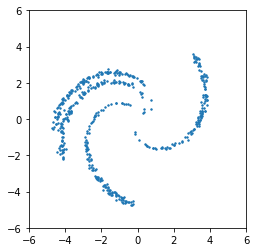

In [5]:
rand_train_data = gen_data(500)
plt.scatter(rand_train_data[:,0],rand_train_data[:,1],2)
plt.xlim([-6,6])
plt.ylim([-6,6])
plt.gca().set_aspect("equal")

In [6]:
net_type = "d"
nlayer = 3
step_size = 1e-2
init_std = 5e-1
niter = 500

ndim = (10,)
npoint = 500
batch_size = 500
ntrain = npoint
nval = 500

np.random.seed(2)

sigma = 10**(tf.Variable(0, dtype="float32"))

lam = 10**(tf.Variable(0, dtype="float32"))
lam2 = 10**(tf.Variable(0, dtype="float32"))

#lam2 = tf.identity(lam)
lam3 = 10**(tf.Variable(0, dtype="float32"))
lam4 = 10**(tf.constant(-3, dtype="float32"))

tb_log_dir = "tb_logs/ds%s_nt%s_nl%d_ss%d_is%d" % (p.name, 
                                                   net_type, 
                                                   nlayer, 
                                                   np.log10(step_size), 
                                                   np.log(init_std))

In [7]:
!rm -rf $tb_log_dir

rm: cannot remove ‘tb_logs/dsspiral_ntd_nl3_ss-2_is0’: Directory not empty


In [8]:
test_data = tf.placeholder("float32", shape=(None, D), name="test_data")
points  = tf.placeholder("float32", shape=(npoint, D), name="points")

rand_val_data = gen_data(nval)
rand_test_data = gen_data(nval)
rand_points = gen_data(npoint)

if hasattr(p, "grad_multiple"):
    test_grad_true = p.grad_multiple(rand_test_data)


print '=====building network'
if net_type=="i":
    kernel  = GaussianKernel(sigma)
elif net_type=="d":
    kernel  = GaussianKernel(sigma)
    layer_1 = LinearSoftNetwork((D,), ndim, init_std=init_std)
    layers = [LinearSoftNetwork(ndim, ndim, init_std=init_std) for i in range(nlayer-1)]
    network = DeepNetwork([layer_1, ] + layers)
    kernel = CompositeKernel(kernel, network)
    #kernel = MixtureKernel([kernel, PolynomialKernel(2)], [1.0, -tf.constant(1e-2, dtype="float32")])
    kernel = NetworkKernel(network)

kn = KernelModel(kernel)

    
kn.set_points(points)
loss, score, train_data, val_data, r_norm, l_norm, curve, alpha_assign = \
    kn.val_score(lam=lam, lam2=lam2, lam3=lam3)

if net_type != "i":
    param_norm = network.get_param_norm()
    loss = loss + 0.5 * lam4 * param_norm
    tf.summary.scalar("param_norm", param_norm)


fv = kn.evaluate_fun(test_data)
gv = kn.evaluate_grad(test_data)

feed   = {train_data: rand_train_data,
          val_data  : rand_val_data,
          test_data : rand_test_data}
feed[points] = feed[train_data]

tf.summary.scalar("score", score)
tf.summary.scalar("loss", loss)
tf.summary.scalar("lam", lam)
tf.summary.scalar("lam2", lam2)
tf.summary.scalar("lam3", lam3)
tf.summary.scalar("rkhs_norm", r_norm)
tf.summary.scalar("l2_norm", l_norm)
tf.summary.scalar("curve", curve)

merged = tf.summary.merge_all()

=====building network


In [9]:
#optimizer = tf.train.GradientDescentOptimizer(step_size)
#optimizer = tf.train.MomentumOptimizer(step_size, momentum=0.9)
optimizer = tf.train.AdamOptimizer(step_size)
gradients, variables = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 10)
train_step = optimizer.apply_gradients(zip(gradients, variables))

config = tf.ConfigProto(device_count={"GPU":1})
config.gpu_options.allow_growth=True




54.9012


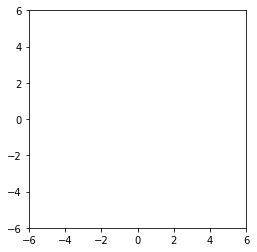

In [10]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)


    if D == 2:
        points_grid = np.array([[i,j] for i in np.linspace(-6,6,5) for j in np.linspace(-6,6,5)])

        K_eval = visualize_kernel(kn, np.linspace(-10,10,100), [0.9], colors="red", points = points_grid);
        print K_eval.mean()

        plt.xlim(-plot_size/2,plot_size/2)
        plt.ylim(-plot_size/2,plot_size/2)

In [11]:
scores = np.zeros(niter+1)
sigmas = np.zeros(niter+1)
lams   = np.zeros(niter+1)
lam2s  = np.zeros(niter+1)
lam3s  = np.zeros(niter+1)

fvs = []

In [12]:
t0 = time()

sess = tf.InteractiveSession()
summary_writer = tf.summary.FileWriter(tb_log_dir, sess.graph)
sess.run(init)

for i in range(niter+1):    

    feed[train_data] = gen_data(ntrain)
    feed[val_data] = gen_data(nval)
    feed[points] = feed[train_data]



    if i % (niter/5) == 0 and D == 2:

        fv_val = sess.run(fv, feed_dict={train_data:feed[train_data], 
                                         test_data:eval_points,
                                         points: feed[points]})
        fv_val -= fv_val.mean()
        fv_val = np.exp(fv_val)
        fv_val /= np.sum(fv_val)
        fvs.append(fv_val) 


    train_step.run(feed_dict=feed)
    scores[i], r_norm_val, l_norm_val, curve_val, alpha_val, summ = sess.run([score, r_norm, l_norm, 
                                                                        curve, kn.alpha, merged], 
        feed_dict=feed)

    summary_writer.add_summary(summ, i)

    sigmas[i], lams[i], lam2s[i] ,lam3s[i]  = sess.run([sigma, lam, lam2, lam3])

    if i % min(100, niter/5) == 0:
        gv_val = gv.eval(feed)
        print '=================='

        print 'Iteration %5d, score %5.3g (%5.3g), time taken %.2f' % (i, scores[i], -D/4.0, time()-t0)
        if hasattr(p, "grad_multiple"):
            print 'true score', true_score(test_grad_true, gv_val)
        print 'sigma: %.5f' % sigma.eval()
        print 'lam, lam2, lam3, lam4', lam.eval(), lam2.eval(), lam3.eval(), lam4.eval()
        print 'alpha: %.5g' % alpha_val.mean()
        print 'rn, ln, c = ', r_norm_val, l_norm_val, curve_val



Iteration     0, score -0.0204 ( -0.5), time taken 2.02
sigma: 1.00000
lam, lam2, lam3, lam4 0.977237 0.977251 0.977255 0.001
alpha: -2.5952e-05
rn, ln, c =  0.0192755 0.000269485 0.00027737
Iteration   100, score -1.11 ( -0.5), time taken 17.36
sigma: 1.00000
lam, lam2, lam3, lam4 0.0628021 0.185094 0.0371111 0.001
alpha: -0.00018004
rn, ln, c =  6.01915 0.00442834 3.09033
Iteration   200, score -4.28 ( -0.5), time taken 32.46
sigma: 1.00000
lam, lam2, lam3, lam4 0.00351359 0.0211962 0.00249786 0.001
alpha: -0.00071022
rn, ln, c =  185.034 5.31459 134.888
Iteration   300, score -6.88 ( -0.5), time taken 47.62
sigma: 1.00000
lam, lam2, lam3, lam4 0.00116826 0.0222808 0.000735766 0.001
alpha: -0.0018619
rn, ln, c =  766.653 449.422 416.496
Iteration   400, score   -11 ( -0.5), time taken 62.77
sigma: 1.00000
lam, lam2, lam3, lam4 0.000437786 0.0313917 0.000248175 0.001
alpha: -0.0035876
rn, ln, c =  3764.83 42.0661 1860.97
Iteration   500, score   -15 ( -0.5), time taken 77.90
sigma: 1.

batch_size = 500

np.random.seed(1)
scores = []

for j in trange(30):
    ge_kn = []
    sc =    []
    
    rand_train_data = gen_data(batch_size)
    rand_test_data = gen_data(batch_size*10)
    
    for i in range(rand_test_data.shape[0]/batch_size):
        d = rand_test_data[i*batch_size:(i+1)*batch_size]
        o1, o2 = sess.run([gv, score], feed_dict={train_data: rand_train_data, 
                                                  test_data: d, 
                                                  points:rand_train_data,
                                                  val_data: d})
        ge_kn += [o1]
        sc    += [o2]

    ge_kn = np.concatenate(ge_kn,0)

    scores.append(np.mean(sc))

scores_i= np.array(scores)

ttest_rel(scores_s, scores_i)

In [13]:
#np.random.seed(3)
batch_size = 500
rand_train_data = gen_data(batch_size)
rand_test_data = gen_data(batch_size*10)

ge_kn = []
sc =    []
for i in range(rand_test_data.shape[0]/batch_size):
    d = rand_test_data[i*batch_size:(i+1)*batch_size]
    o1, o2 = sess.run([gv, score], feed_dict={train_data: rand_train_data, 
                                              test_data: d, 
                                              points:rand_train_data,
                                              val_data: d})
    ge_kn += [o1]
    sc    += [o2]

ge_kn = np.concatenate(ge_kn,0)
if hasattr(p, "grad_multiple"):
    gt = p.grad_multiple(rand_test_data)
print "cv model score: ", np.mean(sc)
if hasattr(p, "grad_multiple"):
    print "cv true score:  ", true_score(ge_kn, gt)

est = KMCLite(m = 500, sigma = np.exp(0.0024), lmbda = np.exp(-9.1224))

est.fit(rand_train_data)

ge = est.grad(rand_test_data)

sc = []
for i in range(rand_test_data.shape[0]/batch_size):
    d = rand_test_data[i*batch_size:(i+1)*batch_size]
    sc += [est.score(d)]
print "gs model score: ", np.mean(sc)
if hasattr(p, "grad_multiple"):
    print "gs true score:  ", true_score(ge, gt)


cv model score:  -8.36545
gs model score:  -30.4725496475


/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:2809: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


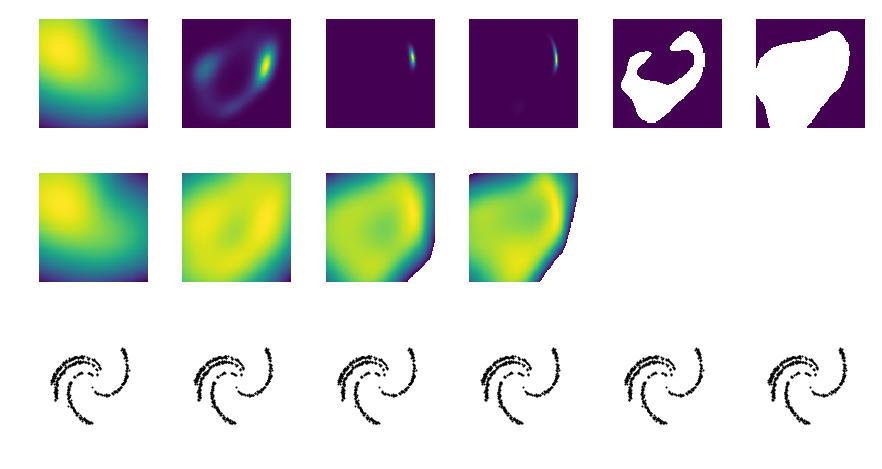

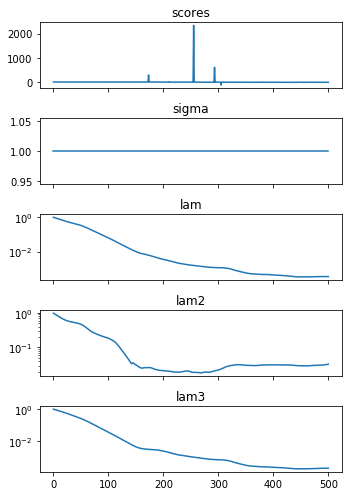

In [14]:
if D == 2:
    nfvs  = len(fvs)
    fig, axes = plt.subplots(3, nfvs,figsize=(15,8), sharex=True, sharey=True)
    rand_data = (ngrid/2)+(rand_train_data*ngrid/plot_size)
    vmin = min(map(np.min, fvs))
    vmax = max(map(np.max, fvs))

    for i in range(len(fvs)):

        iter_number = niter/5*i
        ax = axes[0, i]

        hist = (fvs[i])

        ax.imshow( hist.reshape(ngrid, ngrid).T, origin="lower")
        #ax.set_title("it=%d, sc=%.3f" % (iter_number, scores[iter_number]))
        ax.set_axis_off()

        ax = axes[1, i]
        ax.imshow( np.log(hist).reshape(ngrid, ngrid).T, origin="lower")
        ax.set_axis_off()


        ax = axes[2, i]
        ax.scatter(rand_data[:,0], rand_data[:,1], 1, "k", alpha=1)
        ax.set_axis_off()


    #plt.show()
    #fig.savefig("figs/grid_dist/2d_dist_nt%s_np%d_s%02d.pdf" % (net_type, npoint, seed))
    #fig.savefig("figs/grid_dist/test.pdf") 

fig, axes = plt.subplots(5,1,figsize=(5,7), sharex=True)
ax = axes[0]
ax.plot(scores)
ax.set_title("scores")
ax = axes[1]
ax.plot(sigmas)
ax.set_title("sigma")
ax = axes[2]
ax.plot(lams)
ax.set_title("lam")
ax.set_yscale("log")
ax = axes[3]
ax.plot(lam2s)
ax.set_title("lam2")
ax.set_yscale("log")
ax = axes[4]
ax.plot(lam3s)
ax.set_title("lam3")
ax.set_yscale("log")

fig.tight_layout()
#fig.savefig("figs/grid_dist/test_hist.pdf") 

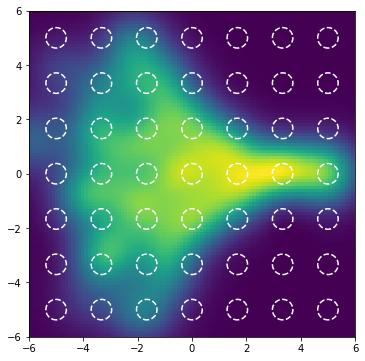

In [271]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,7) for j in np.linspace(-5,5,7)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

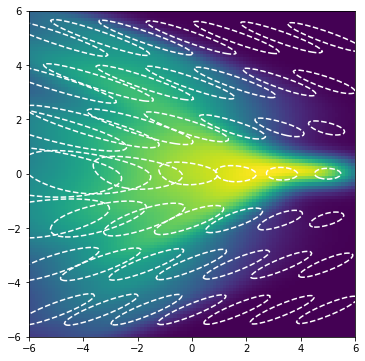

In [262]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,7) for j in np.linspace(-5,5,7)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

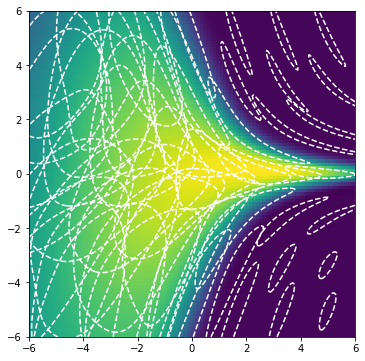

In [252]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,7) for j in np.linspace(-5,5,7)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

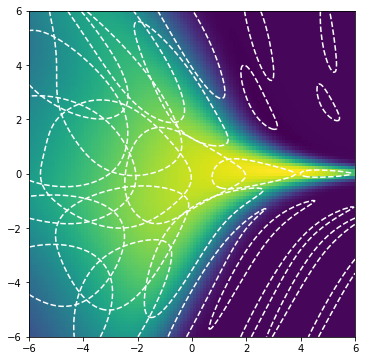

In [282]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,5) for j in np.linspace(-5,5,5)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

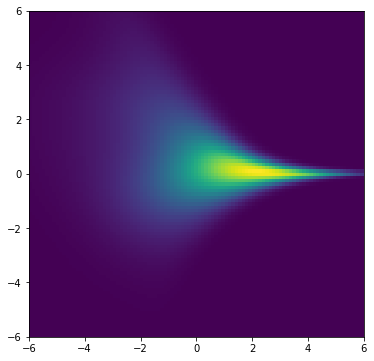

In [18]:
plt.figure(figsize=(6,6))
plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           ((hist.reshape(ngrid,ngrid))).T)

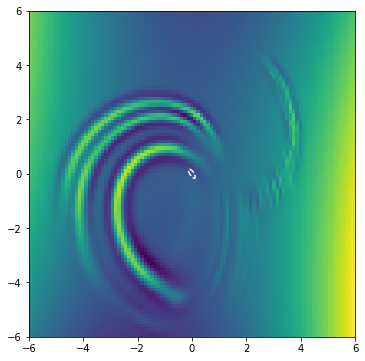

In [18]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,5) for j in np.linspace(-5,5,5)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

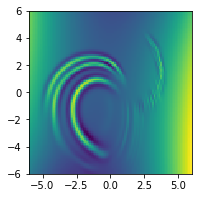

In [26]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,9) for j in np.linspace(-5,5,9)])

plt.figure(figsize=(3,3))
#K = visualize_kernel(kn, np.linspace(-6,6,200), [0.1], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

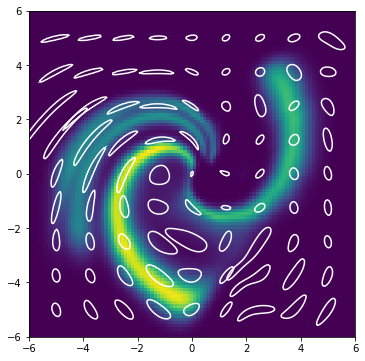

In [59]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,9) for j in np.linspace(-5,5,9)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")